In [1]:
import itertools
import numpy as np
import pandas as pd
import os
import glob
import re
from tqdm import tqdm
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
state = 'ND-'
year = '2021'
file_list = os.listdir('../../Data/NIBRS_ND_2021/original')
csv_list = []
# list only csv files
for file in file_list:
    if re.search('.+csv', file):
        csv_list.append(file)
# dictionary of dataframes corresponding to each csv file, where the key is the
# dataframe name and the value is the actual data frame
df_dict = {file[:-4].lower(): pd.read_csv(os.path.join('..', 'Data', 'NIBRS_ND_2021', 'original', file))
           for file in csv_list}
# Since we chose the state and year, data_year and state columns don't give any extra information
# so we drop them
for key, val in df_dict.items():
    val=val[val.columns.drop(list(val.filter(regex='data_year')))].copy()
    val=val[val.columns.drop(list(val.filter(regex='state')))].copy()
    df_dict[key]=val
# Now we create variables for all the dictionary keys and assign to them
# the value from the respective value of the dictionary according to their key
locals().update(df_dict)

In [3]:
# Combining the different dataframes
df_combined = pd.merge(nibrs_victim_offense, nibrs_offense,
                       how='outer', on='offense_id')
df_combined = pd.merge(df_combined, nibrs_suspect_using,
                       how='outer', on='offense_id')
df_combined = pd.merge(df_combined, nibrs_bias_motivation,
                       how='outer', on='offense_id')
nibrs_offender = pd.merge(nibrs_offender, nibrs_age,
                       how='outer',
                          on='age_id')
nibrs_offender = pd.merge(nibrs_offender, ref_race,
                          on='race_id')
nibrs_offender = pd.merge(nibrs_offender, nibrs_ethnicity,
                          on='ethnicity_id')
nibrs_victim = pd.merge(nibrs_victim, nibrs_age,
                       how='outer',
                        on='age_id')
nibrs_victim = pd.merge(nibrs_victim, ref_race, on='race_id')
nibrs_victim = pd.merge(nibrs_victim, nibrs_ethnicity,
                        on='ethnicity_id')
df_victim_offender = pd.merge(nibrs_victim, nibrs_offender,
                              on='incident_id', how='outer', suffixes=('_victim', '_offender'))
df_combined = pd.merge(df_combined, df_victim_offender,
                       how='outer', left_on=['incident_id', 'victim_id'], right_on=['incident_id',
                                                                                    'victim_id'])
df_combined = pd.merge(df_combined, nibrs_incident,
                       how='outer', on='incident_id')
df_combined = pd.merge(df_combined, nibrs_property,
                       how='outer', on='incident_id')
df_combined = pd.merge(df_combined, nibrs_property_desc,
                       how='outer', on='property_id')
df_combined = pd.merge(df_combined, nibrs_victim_offender_rel, how='outer', left_on=[
    'victim_id', 'offender_id'], right_on=[
        'victim_id', 'offender_id'])
df_combined = pd.merge(df_combined, nibrs_criminal_act,
                       how='outer', on='offense_id')
df_combined = pd.merge(df_combined, nibrs_weapon,
                       how='outer', on='offense_id')
df_combined = pd.merge(df_combined, nibrs_victim_injury,
                       how='outer', on='victim_id')
df_combined = pd.merge(df_combined, agencies,
                       how='outer', on='agency_id')
df_combined = pd.merge(df_combined, nibrs_offense_type, how='outer',
                       on='offense_code')
df_combined = pd.merge(df_combined, nibrs_prop_desc_type,
                       how='outer', on='prop_desc_id')
df_combined = pd.merge(df_combined, nibrs_location_type,
                       how='outer', on='location_id')
df_combined = pd.merge(df_combined, nibrs_bias_list,
                       how='outer', on='bias_id')
df_combined = pd.merge(df_combined, nibrs_weapon_type,
                       how='outer', on='weapon_id')
df_combined = pd.merge(df_combined, nibrs_relationship,
                       how='outer', on='relationship_id')
df_combined = pd.merge(df_combined, nibrs_victim_circumstances,
                       how='outer', on='victim_id')
df_combined = pd.merge(df_combined, nibrs_circumstances,
                       how='outer', on='circumstances_id')
df_combined = pd.merge(df_combined, nibrs_criminal_act_type,
                       how='outer', on='criminal_act_id')
df_combined = pd.merge(df_combined, nibrs_activity_type,
                       how='outer', on='activity_type_id')
df_combined = pd.merge(df_combined, nibrs_victim_type,
                       how='outer', on='victim_type_id')
df_combined = pd.merge(df_combined, nibrs_prop_loss_type,
                       how='outer', on='prop_loss_id')
df_combined = pd.merge(df_combined, nibrs_injury,
                       how='outer', on='injury_id')
df_combined = pd.merge(df_combined, nibrs_using_list, on='suspect_using_id')

In [4]:
# we create a copy of the combined dataframe to work on
df_cleaned=df_combined.copy()
# Let's see the complete dataframe
pd.set_option('display.max_columns', None)
df_cleaned

,victim_id,offense_id,incident_id,offense_code,attempt_complete_flag,location_id,num_premises_entered,method_entry_code,suspect_using_id,bias_id,victim_seq_num,victim_type_id,assignment_type_id,activity_type_id,outside_agency_id,age_id_victim,age_num_victim,sex_code_victim,race_id_victim,ethnicity_id_victim,resident_status_code,age_range_low_num_victim,age_code_range_high,age_code_victim,age_name_victim,race_code_victim,race_desc_victim,sort_order_victim,start_year_victim,end_year_victim,notes_victim,ethnicity_code_victim,ethnicity_name_victim,offender_id,offender_seq_num,age_id_offender,age_num_offender,sex_code_offender,race_id_offender,ethnicity_id_offender,age_range_low_num_offender,age_range_high_num,age_code_offender,age_name_offender,race_code_offender,race_desc_offender,sort_order_offender,start_year_offender,end_year_offender,notes_offender,ethnicity_code_offender,ethnicity_name_offender,agency_id,nibrs_month_id,cargo_theft_flag,submission_date,incident_date,report_date_flag,incident_hour,cleared_except_id,cleared_except_date,incident_status,data_home,orig_format,did,property_id,prop_loss_id,stolen_count,recovered_count,prop_desc_id,property_value,date_recovered,nibrs_prop_desc_id,relationship_id,nibrs_victim_offender_id,criminal_act_id,weapon_id,nibrs_weapon_id,injury_id,yearly_agency_id,ori,legacy_ori,covered_by_legacy_ori,direct_contributor_flag,dormant_flag,dormant_year,reporting_type,ucr_agency_name,ncic_agency_name,pub_agency_name,pub_agency_unit,agency_status,division_code,division_name,region_code,region_name,region_desc,agency_type_name,population,submitting_agency_id,sai,submitting_agency_name,suburban_area_flag,population_group_id,population_group_code,population_group_desc,parent_pop_group_code,parent_pop_group_desc,mip_flag,pop_sort_order,summary_rape_def,pe_reported_flag,male_officer,male_civilian,male_officer+male_civilian,female_officer,female_civilian,female_officer+female_civilian,officer_rate,employee_rate,nibrs_cert_date,nibrs_start_date,nibrs_leoka_start_date,nibrs_ct_start_date,nibrs_multi_bias_start_date,nibrs_off_eth_start_date,covered_flag,county_name,msa_name,publishable_flag,participated,nibrs_participated,offense_name,crime_against,ct_flag,hc_flag,hc_code,offense_category_name,offense_group,prop_desc_name,prop_desc_code,location_code,location_name,bias_code,bias_category,bias_desc,weapon_code,weapon_name,shr_flag,relationship_code,relationship_name,circumstances_id,justifiable_force_id,circumstance_type,circumstance_code,circumstance_name,criminal_act_code,criminal_act_name,criminal_act_desc,activity_type_code,activity_type_name,victim_type_code,victim_type_name,prop_loss_name,prop_loss_desc,injury_code,injury_name,suspect_using_code,suspect_using_name
0,147277785.0,161424052.0,134025398.0,290,C,25.0,NaN,NaN,4.0,88.0,1.0,3.0,NaN,NaN,NaN,104.0,NS,X,99.0,50.0,NaN,NaN,NaN,NS,Not Specified,NS,Not Specified,99.0,NaN,NaN,Race is not specified,X,Not Specified,152300535.0,0.0,104.0,NS,X,99.0,50.0,NaN,NaN,NS,Not Specified,NS,Not Specified,99.0,NaN,NaN,Race is not specified,X,Not Specified,11696.0,20490445.0,f,2021-02-04 08:14:02.208465,2021-01-04,f,15.0,6.0,NaN,ACCEPTED,NaN,X,93919981.0,135376569.0,4.0,NaN,NaN,63.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116962021.0,ND0010000,ND0010000,NaN,N,N,NaN,I,ADAMS,ADAMS CO SO HETTINGER,Adams,NaN,A,4.0,West North Central,2.0,Midwest,Region II,County,2169.0,23380.0,NDUCR0001,Attorney General's Office Bureau of Criminal I...,N,16.0,8D,"Non-MSA counties under 10,000",8.0,Non-MSA Counties,N,16.0,NaN,Y,5.0,0.0,5.0,0.0,1.0,1.0,2.3,2.8,1991-01-01,1991-01-01,1991-01-01,2014-09-01,2021-01-01,2021-01-01,N,ADAMS,Not Specified,Y,Y,Y,Destruction/Damage/Vandalism of Property,Property,f,t,11,Destruction/Damage/Vandalism of Property,A,Other,77.0,13.0,Highway/Road/Alley/Street/Sidewalk,88.0,None/Unknown,None (no bias),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G,Government,Destroyed/Damaged/Vandalized,Destroyed/Damaged/Vandalized,NaN,NaN,N,Not Applicable
1,16402

In [5]:
# Transform date to datetime format
df_cleaned['incident_date'] = pd.to_datetime(df_cleaned['incident_date'], format="%Y-%m-%d")

# Since crime is done by humans and we know that the date has an effect on human behavior,
# we do some feature engineering extracting new variables from the date data could be useful
# for our predictions. We extract day of the week,if it is weekend or a holiday, month,
# day of the month, and week of the year
df_cleaned['incident_day'] = df_cleaned['incident_date'].dt.dayofweek
df_cleaned['incident_isweekend'] = df_cleaned['incident_day'] > 4
cal = USFederalHolidayCalendar()
holidays = cal.holidays()
df_cleaned['incident_is_holiday'] = df_cleaned['incident_date'].isin(holidays)
df_cleaned['incident_month'] = df_cleaned['incident_date'].dt.month
df_cleaned['incident_dayofmonth'] = df_cleaned['incident_date'].dt.day
df_cleaned['incident_weekofyear'] =df_cleaned['incident_date'].dt.isocalendar().week

In [6]:
# Splitting crimes to different categories (crimes againts people, society and property)
grouped = df_cleaned.groupby(df_cleaned.crime_against)
df_person = grouped.get_group("Person")
df_society = grouped.get_group("Society")
df_property = grouped.get_group("Property")

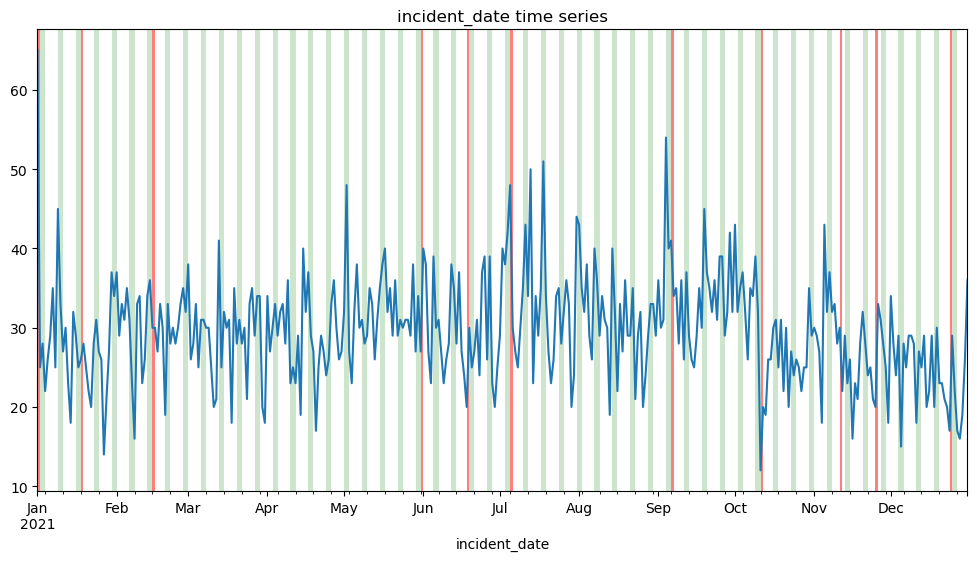

In [7]:
# Indicating whether the incident happened on a weekend or a US national holiday
weekends=sorted(df_person[df_person['incident_isweekend']==True].incident_date.unique())
holidays=sorted(df_person[df_person['incident_is_holiday']==True].incident_date.unique())
df_person.groupby('incident_date')['incident_id'].nunique().plot(title='incident_date'+' time series',figsize=(12,6))
i = 0
while i < len(weekends)-1:
    plt.axvspan(weekends[i], weekends[i+1]+np.timedelta64(1,'D'), facecolor='green', edgecolor='none', alpha=.2)
    i += 2
for i in range(len(holidays)):
    plt.axvspan(holidays[i], holidays[i]+np.timedelta64(1,'D'), facecolor='red', edgecolor='none', alpha=.5)

In [8]:
# Remove columns with only null values
for df in [df_person,df_property,df_society]:
    df.dropna(thresh=2, axis=1,inplace=True)

# Remove all columns where there is a class that represents more than 90% of the data
for df in [df_person,df_property,df_society]:
    very_imbalanced_columns=[]
    for col in tqdm(df.columns):
        if df[col].value_counts(normalize=True,dropna=False).max() >= 0.90:
            very_imbalanced_columns.append(col)
    df.drop(very_imbalanced_columns, axis=1,inplace=True)

# Remove columns with more than 90% null values
for df in [df_person,df_property,df_society]:
    # Remove all columns where there is more than 90% null values
    to_remove=[]
    for column,null_percent in enumerate((df.isna().sum()/df.shape[0]).to_frame().values):
        if null_percent >0.90:
            to_remove.append(column)
            #print(null_percent,column)
    df.drop(columns=df.columns[to_remove], inplace=True)

C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_1920\4260821826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(thresh=2, axis=1,inplace=True)
C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_1920\4260821826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(thresh=2, axis=1,inplace=True)
C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_1920\4260821826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.

In [9]:
# Remove irrelevant columns
for df in [df_person,df_property,df_society]:
    df.drop(columns=['num_premises_entered',
                          'age_range_low_num_victim',
                         'notes_victim'
                         ,'population_group_desc','county_name',
                         'age_range_low_num_offender',
                         'notes_offender', 'submission_date',
                         'cleared_except_date','offense_category_name',
                         'incident_status', 'did','suspected_drug_name','drug_measure_name',
                         'date_recovered', 'ori', 'legacy_ori',
                         'ucr_agency_name', 'ncic_agency_name',
                         'pub_agency_unit','prop_loss_desc',
                         'suburban_area_flag', 'parent_pop_group_desc',
                         'mip_flag', 'pe_reported_flag',
                         'nibrs_start_date', 'nibrs_leoka_start_date',
                         'nibrs_ct_start_date', 'msa_name', 'ct_flag',
                         'age_range_high_num', 'est_drug_qty',
                         'male_officer','male_civilian','criminal_act_desc',
                         'male_officer+male_civilian', 'female_officer',
                         'female_civilian', 'female_officer+female_civilian',
                         'officer_rate', 'hc_flag', 'shr_flag', 'employee_rate',
                         ], inplace=True, axis=1,errors='ignore')

C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_1920\1457571155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['num_premises_entered',
C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_1920\1457571155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['num_premises_entered',
C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_1920\1457571155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.

In [10]:
# Looking at nibrs_age csv we see that there are a minority of ages that don't correspond to a specific age. We'll remove this for simplicity
df_person=df_person.loc[~df_person['age_id_victim'].isin([1,2,3,103,104])]
df_person=df_person.loc[~df_person['age_id_offender'].isin([1,2,3,103,104])]

# Let's remove columns that don't give valuable information like id and code columns
for df in [df_person,df_property,df_society]:
    (df.drop(columns=[i for i in list(df.filter(regex='_id'))],errors='ignore',inplace=True))
    (df.drop(columns=[i for i in list(df.filter(regex='_code')) if i!='resident_status_code'],errors='ignore',inplace=True))

# Transform age to numeric
df_person["age_num_victim"] = pd.to_numeric(df_person["age_num_victim"])
df_person["age_num_offender"] = pd.to_numeric(df_person["age_num_offender"])

C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_1920\4271963318.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  (df.drop(columns=[i for i in list(df.filter(regex='_id'))],errors='ignore',inplace=True))
C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_1920\4271963318.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  (df.drop(columns=[i for i in list(df.filter(regex='_code')) if i!='resident_status_code'],errors='ignore',inplace=True))
C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_1920\4271963318.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

In [11]:
inputFeature = df_person[['victim_seq_num','age_num_victim','resident_status_code','race_desc_victim',
'ethnicity_name_victim','incident_hour','pub_agency_name','offense_name','location_name','weapon_name','population'
,'injury_name','incident_day','incident_isweekend','incident_month','incident_dayofmonth','incident_weekofyear','relationship_name']]
numerical_output = df_person[['age_num_offender']]
categorial_output = df_person[['race_desc_offender']]
inputFeature

,victim_seq_num,age_num_victim,resident_status_code,race_desc_victim,ethnicity_name_victim,incident_hour,pub_agency_name,offense_name,location_name,weapon_name,population,injury_name,incident_day,incident_isweekend,incident_month,incident_dayofmonth,incident_weekofyear,relationship_name
6664,1.0,17,NaN,White,Not Hispanic or Latino,21.0,Fargo,Intimidation,Amusement Park,NaN,127313.0,NaN,1,False,4,6,14,Victim Was Stranger
6665,2.0,19,NaN,White,Not Hispanic or Latino,21.0,Fargo,Intimidation,Amusement Park,NaN,127313.0,NaN,1,False,4,6,14,Victim Was Stranger
6666,3.0,17,R,White,Not Hispanic or Latino,21.0,Fargo,Intimidation,Amusement Park,NaN,127313.0,NaN,1,False,4,6,14,Victim Was Stranger
6667,4.0,17,R,White,Not Hispanic or Latino,21.0,Fargo,Intimidation,Amusement Park,NaN,127313.0,NaN,1,False,4,6,14,Victim Was Stranger
6691,1.0,20,R,White,Not Hispanic or Latino,0.0,Grand Forks,Intimidation,Residence/Home,NaN,56253.0,NaN,2,False,11,10,45,Victim Was Acquaintance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124433,2.0,34,N,Black or African American,Not Hispanic or Latino,8.0,Fargo,Simple Assault,Residence/Home,Other,127313.0,NaN,6,True,10,3,39,Victim Was Offender
124434,1.0,9,R,White,Not Specified,0.0,Grand Forks,Rape,Residence/Home,Personal Weapons,56253.0,NaN,4,False,3,26,12,Victim Was Child of Boyfriend or Girlfriend
124435,1.0,19,R,White,Not Specified,0.0,Rugby,Fondling,Residence/Home,Drugs/Narcotics/Sleeping Pills,2538.0,Unconscious,4,False,7,9,27,Victim Was Friend
124436,1.0,37,N,White,Not Hispanic or Latino,9.0,Fargo,Aggravated Assault,Hotel/Motel/Etc.,Personal Weapons,127313.0,Unconscious,3,False,9,2,35,Victim Was Boyfriend/Girlfriend


In [15]:
if not os.path.exists('../Data/NIBRS_ND_2021/processed'):
    os.mkdir('../Data/NIBRS_ND_2021/processed')
inputFeature.to_csv('../Data/NIBRS_ND_2021/processed/input.csv'), numerical_output.to_csv('../Data/NIBRS_ND_2021/processed/num_out.csv'), categorial_output.to_csv('../Data/NIBRS_ND_2021/processed/cat_out.csv')

(None, None, None)